# How good is the food?

*Rafael Cardenas* 

*Disclaimer: This project is still under construction, at this date (19.07.20) the classification algorithm is being fine tunned to increase its performance*

### Project Outline


1. [Problem background and business value](#Problem_Backgound)
2. [Objectives and problem statement](#Objectives)
3. [EDA](#EDA)
5. [Algorithm](#Classifier)
6. [Conclusions and next steps](#Further)

# Background
<a id='Problem_Backgound'><a/>

Sentiment Analysis has raised in parallel with the ammount of opinions on the web. Part of a broader field known as opinion mining, in the early 2000's gained popularity as businesses started to receive more and more feedback for their products in the form of comments.
As data volumes began to increase in size, methods to extract information were developed, sentiment analysis is still considered as a robust one to quantify opinions of the masses.

Fast forward to more recent times, sentiment analysis has extended farther than product reviews; now ranging from *brand perception* to opinion mining in sensible topics such as the elections.

##### Business Value:
At the end of the day, data **science in a company serves the ultimate goal of a business: Profit generation.** Sentiment Analysis has a broad range of applications in the real world. Successful companies mine opinions of a specific brand/product from several sources to quickly know what is popular opinion of the product/brand and identify the possible reasons; with that, companies could make better decisions in difficult times.
In this same vein, businesses can identify which are the most important factors that lead the costumer to incline towards a positive or negative opinion and based on that, make the pertinent moves.


# Objectives and problem statement
<a id='Objectives'></a>

This project has been done from a didactical point of view, approaching the problem with the combination of already existing resources and my own initiative. That being said, I did set specific goals and success metrics for this project:

* No libraries *(NLTK, SpaCy)* NLP pipeline: Self imposed restriction to manually implement text preparation and feature extraction.
* At least 85% accuracy on classification, taking as benchmark papers on Sentiment Analysis **([Pang, et al. 2002](https://www.aclweb.org/anthology/W02-1011/) & [Potts, et al. 2011](https://web.stanford.edu/~cgpotts/papers/potts-salt20-negation.pdf))**
* Deploy the model. ML models that does not go beyond a notebook provide no value to the business, for a model to be useful, an API should be available

##### Problem Statement

The questions that are going to be answer through this analysis.

1. What makes a good/bad review?
2. In which aspects should restaurants improbe to gain/mantain customers?
3. Can we identify fake reviews? i.e reviews written by owners

# Exploratory Data Analysis
<a id='EDA'><a/>

In order to keep the focus of this project on the analysis part of the pipeline, I used the [*Yelp Dataset*](https://www.yelp.com/dataset/download) provided by Yelp.
This part of the documentation focuses on the initial analysis of the data to make myself familiar with the data and make my first assumptions and paths that I could take towards the analysis.

#### Starting with the preprocessing...

In [305]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
from wordcloud import WordCloud, STOPWORDS

##### Load the 'business' dataset

In [306]:
df2 = pd.read_json("yelp_academic_dataset_business.json", chunksize = 1000, lines = True)
drop_cols = ['address', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open','attributes', 'hours']

In [307]:
chunks = []
a = 0
for chunk in df2:
    a += 1
    chunk_b = chunk.drop(drop_cols, axis = 1)
    restas = chunk_b[chunk_b['categories'].str.contains('restaurant', case = False, na = False)]
    chunks.append(restas)
restaurants = pd.concat(chunks, ignore_index= True, join='outer')

##### Load the reviews dataset
Merge using ONLY the 'Restaurants' category

In [308]:
reviews_raw = pd.read_json("yelp_academic_dataset_review.json", chunksize=100000, lines = True)
drop_cols = ['review_id', 'user_id','useful', 'funny', 'cool', 'date']

Using merge instead of join because we want to join in another column other than the index

In [309]:
a = 0
for chunk in reviews_raw:
    a += 1
    reviews = chunk.drop(drop_cols, axis = 1)
    data = restaurants.merge(reviews, left_on = 'business_id', right_on = 'business_id',how = 'inner')
    if a == 1:
        break

##### The 'text' column is the data to be preprocessed
(delete this)


To be done: 
* Delete all number 3 i.e neutral 
* Same number of positive as negatives
* Shuffle the data

In [310]:
data_raw = data.copy()
data_raw['Sentiment'] = data_raw['stars'].apply(lambda x: 1 if x > 3 else 0)  
data.head(2)

,business_id,name,city,categories,stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5,I love the empanadas from the Empanadas House!...
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,"Definitely under new management, and the dinin..."


In [311]:
"There are: " + str(data.shape[0]) + " reviews on the data set"

'There are: 66698 reviews on the data set'

Text(0.5, 1.0, 'Number of reviews by stars')

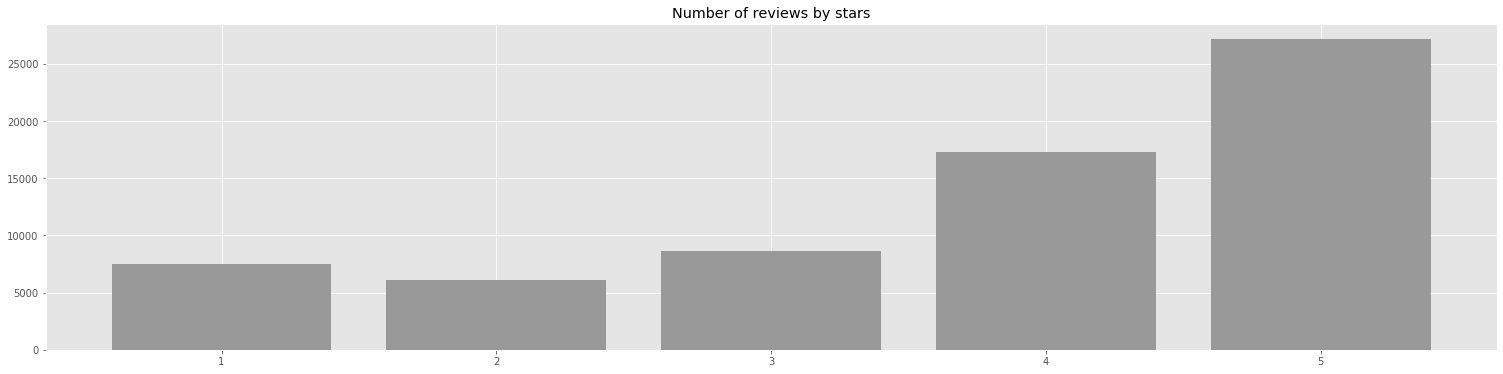

In [312]:
data = data.loc[:, ['name', 'stars', 'text']]
x = (data['stars'].value_counts()).index
y = (data['stars'].value_counts()).values
_ = plt.bar(x, y, color = '#999999')
plt.title("Number of reviews by stars")

**As we can see, the reviews are imbalanced, biased towards positive reviews**

Reviews with "1" and "2" stars fall into the negative (0) category, "4" and "5" in to the positive (1), but as we just saw, there are many more positive revies than negartive, thus, we use "3 stars" as negative (0) to augment the data and  balance the classes


In [344]:
def balance_sample(data, no_samples):
    neg_half = list((data[data['stars'] <=3]).index)
    neg_half = neg_half[:no_samples]
    pos_half = list(set(range(data.shape[0])) - set(neg_half))
    pos_half = pos_half[0:len(neg_half)]
    pos_half.extend(neg_half)
    dropper = list(set(range(data.shape[0])) - set(pos_half))
    data.drop(index = dropper, inplace = True)
    data['Sentiment'] = data['stars'].apply(lambda x: 1 if x > 3 else 0)  

#### For demonstration purposes, only 2000 samples of each class  are selected

In [345]:
balance_sample(data, 2000)

In [346]:
data['Sentiment'].value_counts()

1    2000
0    2000
Name: Sentiment, dtype: int64

##### Limiting data size
We use the previous function to balance the classes in terms of label and to reduce the number of samples that are going to be processed in the following steps. This was introduced to control the size of the data because of computational limitations. In this case we select 2000

Text(0.5, 1.0, 'Number of reviews by class')

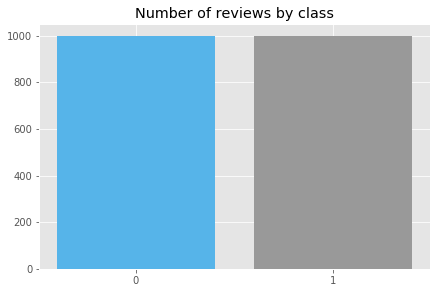

In [316]:
fig = plt.figure(figsize=(7,4.5))
x = (data['Sentiment'].value_counts()).index
y = (data['Sentiment'].value_counts()).values
_ = plt.bar(x, y, color=['#999999','#56B4E9'])
plt.xticks([0,1])
plt.title("Number of reviews by class")

### -------------------------------------------------------------------------------------

### NLP pipeline
*Image Source: SpaCy*

![NLP pipeline](./Images/NLP_pipeline.png "Source: SpaCy")

As the image above explains, the first natural step for NLP pipeline is the tokenizer, that is the conversion of words into any more manageable form, tipically it is done simply separating words by blank space.
This tokenizer can be done with NLTK, in the following cells, a Prove of Concept (PoC) of the NLTK Tokenizer is done.
Once the words are converted into single "units" further processing such as *Bag of Words* can be implemented

### PoC for NLTK
*Used as starting point for self implemented tokenizer*

In [317]:
raw2 = data['text'][0]
raw2

"I love the empanadas from the Empanadas House! They're authentic Argentine empanadas and they are delicious! If you have a sweet tooth try the Dulce de Leche with Walnuts!"

In [318]:
from nltk.probability import FreqDist
counter = FreqDist()

In [319]:
tokenizer = []
a = 0
for i in raw2:
    words = i.lower()
    words = words.split()
    for word in words:
        a += 1
        counter[word] += 1
        if word not in tokenizer:
            tokenizer.append(word)
len(tokenizer)
tokenizer
words = raw2.split()
for word in words:
    a += 1
len(words)

29

**NLTK tokenizer gives would give this result**

In [320]:
print(words)

['I', 'love', 'the', 'empanadas', 'from', 'the', 'Empanadas', 'House!', "They're", 'authentic', 'Argentine', 'empanadas', 'and', 'they', 'are', 'delicious!', 'If', 'you', 'have', 'a', 'sweet', 'tooth', 'try', 'the', 'Dulce', 'de', 'Leche', 'with', 'Walnuts!']


##### NLTK also has an out-of-the-box counter that can be used to spot the most common words in the corpus

In [321]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [322]:
#out of the box tokenizer and counter
from nltk.probability import FreqDist
counter = FreqDist()
tokens_nltk = word_tokenize(raw2)

tokenizer = []
for word in tokens_nltk:
    counter[word.lower()] += 1

counter.most_common(2)

[('the', 3), ('empanadas', 3)]

With this example is clear the existence of **Stop words**. Common words in the language that does not have semantical value but only serve as connectors or to round up the meaning of an idea. The word: *the* is one of the most common stop words in english

**Other commands of NLTK**

```Python
counter.B() #is the number of unique words
counter.N #is the total number of words
set(stopwords.words("english")) #to display the dictionary of stop words by NLTK
```

### Negation tagging

When dealing with sentiments, sometimes only tokenizing is not enough to capture the relations of the words on the sentence. Specifically, under a negation scope, to capture the semantic value that provide negation expresions, the following method was proposed by [Das and Chen (2001)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.202.6418&rep=rep1&type=pdf) and [Pang et al. (2002)](https://www.aclweb.org/anthology/W02-1011/).
The reasoning is the following.

Suppose we have the following sentence we want to tokenize

"I did not like the movie that much because of the music, however, the casting was good enough"

With the *Sentiment Aware Toekenizer*, the resulting tokens would be:
[I, did, not, like_NOT, the_NOT, movie_NOT, that_NOT, much_NOT, because_NOT, of_NOT, the_NOT, music_NOT, however, the, casting, was, good, enough]

This would take into account the negation effect over the sentence until the first punctuation mark. i.e  **^[.:;!?]$** (in regex)

### Negation tagging implementation

In [323]:
def pesimist(text):
    """
    Function that applies the negation tagging to the string of text passed. Based on Das and Che, 2001 and
    Pang, L. et al. (2002)
    """
    x = str(text) + "."
    x = x.split()
    hasta = 0
    desde = 0
    c = 0
    j = 0
    passer = False
    for k in range(len(x)):
        #print(j)
        #print(k)
        #if not passer:
            #continue
        passer = True

        i = x[k]
        negation_string = r"""
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|but|doesnt|didnt|isnt|arent|aint
        )$|n't
        """
        #print("first")
        c +=1
        #match = re.search(r'\bthe\b',i)
        neg = re.compile(negation_string, re.VERBOSE | re.I | re.UNICODE)
        match = neg.findall(i)
        #print(i + "i")
        #print('desde', desde)
        #print(f'hasta menos desde es: {hasta - desde} y c es {c}')
        if c < (hasta - desde):
            continue
        if match:
            c = 0
            desde = k + 1
            #print(c - 1)
            #j = i
            jump = k
            for j in range(jump, 100):

                #print(j)
                try:
                    comma = re.search(r'[.:;!?]', x[j])
                    #print("second")
                    if comma:
                        hasta = j + 1
                        c += 1
                        
                        #this try to avoid error if there is no punctuation error before the phrase ends
                        try:
                            for i in range(desde, hasta):
                                repl = re.match(r'\w+', x[i])
                                x[i] = repl.group() + "_NOT"
                            
                            c = 0
                            break
                        except:
                            #print(' '.join(x))
                            c = 0
                            break
                except:
                    pass
        if match:
            continue



                #continue


            #else:
                #continue
            #break
    xx = ' '.join(x)
    return xx

## Tokenizer


#### Applying the previous function to the data frame

In [324]:
from Utils.happyfuntokenizing import Tokenizer

In [325]:
def tiktokens(raw_data):
    """
    Function that applies tokenization to the data frame based on happyfuntokenizing.Tokenizer
    ----------
    Atributes:
        raw_data: pandas dataframe
            Dataframe containing the reviews to be tokenized
    """
    raw_data["sample"] = raw_data.loc[:, "text"].apply(pesimist)
    tok = Tokenizer()
    raw_data["tokens"] = raw_data.loc[:, "sample"].apply(tok.tokenize)
    raw_data.reset_index(inplace = True)
    #print(raw_data["Sentiment"].value_counts())

In [326]:
#delete this
tok = Tokenizer()
tok.__dict__

{'preserve_case': False, 'all_in': False}

## Removing 'filler' words
Counting the most common words over all the corpora it is discovered that the most common ones are **stop words** which by nature, don't carry a lot of meaning from which the classifier could take advantage in its task. To reduce this noise and using heuristics, the first 15 words are going to be removed. 

In the following cells, the most common words are shown

In [350]:
data2 = data.copy()

In [351]:
data2.shape

(4000, 10)

In [329]:
tiktokens(data2)
tiktokens(data_raw)

In [330]:
reviews = data2['tokens'].to_numpy()
review1 = reviews[0]
print(review1)

['i', 'love', 'the', 'empanadas', 'from', 'the', 'empanadas', 'house', "they're", 'authentic', 'argentine', 'empanadas', 'and', 'they', 'are', 'delicious', 'if', 'you', 'have', 'a', 'sweet', 'tooth', 'try', 'the', 'dulce', 'de', 'leche', 'with', 'walnuts']


## Bag of words

It is a dictionary that includes all the words present on the processed corpus, posteriorly used on the word-vector transformation process

The following function can restrict the number of words that are going to be in the bag of words, this allows to control the number of dimensions that the classifier is dealing with.

As is is shown in the latter graph, the frecuency of the words is very low relative to the first 500 words, this is an indication that the most frecuent words carry the most ammount of information, from there, other words add additional information to the classifier.

In [331]:
def restricted_corpus_builder(corpus_size, raw_reviews, stop = False):
    """
    Create the bag of words with the first 'corpus_size' most common words present on the reviews
    -----------
    corpus_size : number of words to be included on de bow
    raw_reviews : all the column of the raw reviews
    """
    if stop:
        stops = list(STOPWORDS)
    else:
        stops = []
    bow = []
    bow_counter = []
    counter = FreqDist()
    for review in raw_reviews:
        for word in review:
            if word in stops:
                continue
            else:
                counter[word] += 1
    counting = counter.most_common(corpus_size)
    for word in counting:
        bow.append(word[0])
        bow_counter.append(word[1])
    return counter, bow, bow_counter, len(counter)  
dictio, bow, bow_counted, lenght = restricted_corpus_builder(3000, reviews, stop = True)

In [332]:
len(bow_counted)

3000

In [333]:
print("There are {} words in this corpus".format(lenght))

There are 12755 words in this corpus


##### The first 100 seem to be the most common among this domain (restaurants)
However, this is missleading, because the most frecuent words are stopwords:

Text(0.5, 1.0, 'Most common words in a corpus of 3000 reviews')

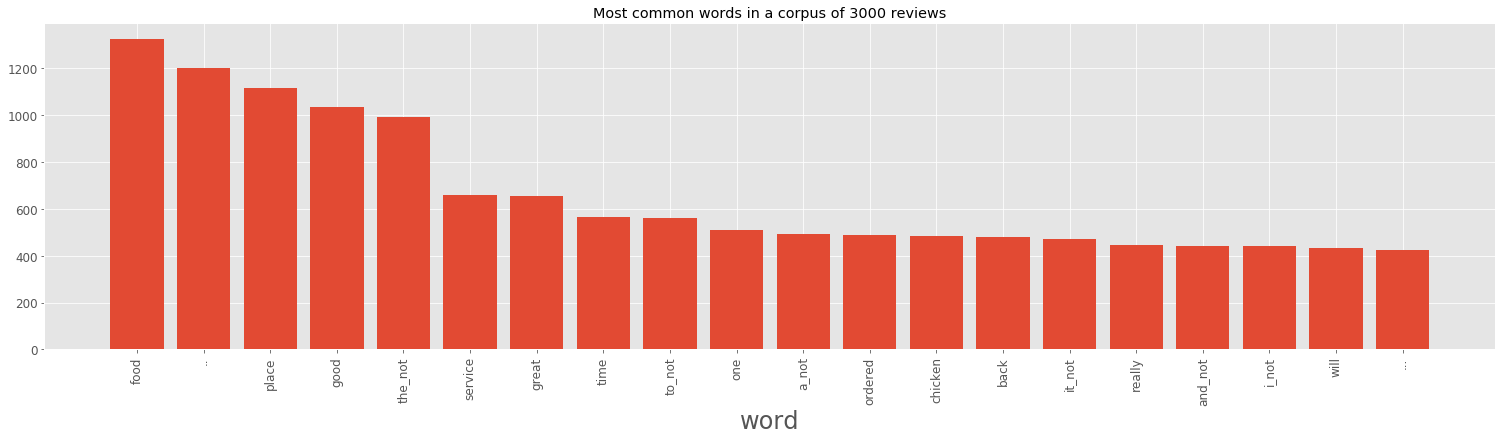

In [334]:
freqq = dict(zip(bow[:20], bow_counted[:20]))
plt.bar(freqq.keys(), freqq.values())
plt.xlabel('word', fontsize=24)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.title("Most common words in a corpus of 3000 reviews")

#### As can be seen, until the 18th most common word we found real meaning with "food" but before that, it is clear how the first 3 words don't really contribute with useful semantics

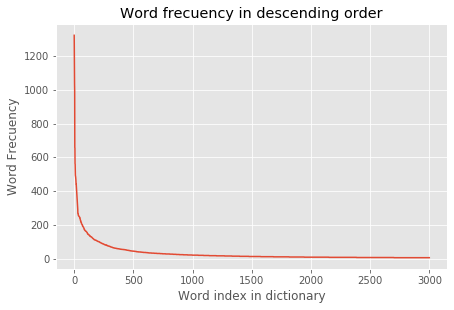

<Figure size 72x216 with 0 Axes>

In [335]:
fig = plt.figure(figsize=(7,4.5))
ax = fig.add_subplot(111)
plt.plot((np.linspace(0, len(bow_counted), num=len(bow_counted))), bow_counted)
plt.title("Word frecuency in descending order")
plt.xlabel("Word index in dictionary")
plt.ylabel("Word Frecuency")
plt.figure(figsize=(1,3))
plt.show()

On the previous graph, again can be seen the frecuency distribution of the words on the previously created BoW

#### A word cloud is created using the first 2000 most common words on the corpus, after removing a set of english stopwords commonly accepted in the literature

In [336]:
stopww = list(STOPWORDS)
stopww2 = []
for i in stopww:
    nn = i + "_not"
    stopww2.append(nn)
for i in stopww2:
    stopww.append(i)

In [337]:
word_dictionary_freq = dict(zip(bow, bow_counted))
for key, value in word_dictionary_freq.items():
    if key in stopww:
        word_dictionary_freq[key] = 0

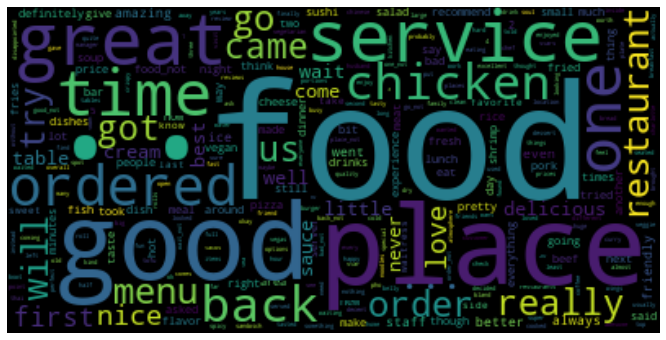

In [338]:
wc = WordCloud(max_words=2000, background_color="black", stopwords=stopww)
wc.generate_from_frequencies(word_dictionary_freq)
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.rcParams["figure.figsize"] = (26,6)
plt.show()

Several conclusions can be obtained from this word cloud:
* The data set is not balanced, we can see a lot of positive words, representing high frecuencies of those words on the corpus
* Words such as *chicken, food* indicate the existence of a domain specific corpus, and thus, classifier

##### Utility functions to make the word-vector representations

In [339]:
def vectorizer2(bow, ind_review):
    """
    Vectorize the review based on the counting of the words present on the review, 
    the appereances are counted on a dictionary, the value of the words (keys) that are not present remain as '0'
    ----------
    bow : bag of all the words in list (unique values)
    ind_review = indiviual review to be vectorized
    ommited_words: number of most common words that are going to be ommited
    """

    counter = dict.fromkeys(bow, 0)
    for word in ind_review:
        try:
            if word in ommitted_words:
                continue
            else:
                counter[word] += 1
        except:
            pass
    return list(counter.values())

In [340]:
def matrix_builder2(bow, review_series):
    """
    Creates the matrix of features based on the term frecuency vectors created by the function vectorizer
    ----------
    bow: bag of words
    review_series : pandas object (series)  i.e dataframe[name_of_column]
    ommited_words: number of most common words that are going to be ommited
    """
    X = []
    i = 0
    
    for review in review_series:
        word_vector = vectorizer2(bow, review)
        if i < 1:
            X = np.array([word_vector])
            i += 1
            continue
        X = np.append(X, [word_vector], axis = 0)
    return X

# Classification Algorithm

<a id='Classifier'><a/>

![Sentiment Pipeline](./Images/Pipe_class.png "Sentiment Pipeline")

In [352]:
review_list = data2['tokens'].to_numpy()

#### We construct a pipeline with cross validation to systematically evaluate the classifiers
First, an unit-variance scaler and SVM are used
The variable ``param_grid`` shows the parameters that *GridSearchCV* is going to use as search space to look for the best classifier in terms of accuracy

**Features used by the classifier:**
* Unigrams

In [353]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
scaler = StandardScaler()
pipe = make_pipeline(StandardScaler(), SVC())
param_grid = dict(svc__C = [1e-5, 1e-3, 1, 1e3, 1e5], svc__kernel = ['rbf', 'linear'])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

##### The dataset is a balanced set of 4000 examples (50% of each category) and the performance of the classifier is shown as function of the number of words (dimensions) from which the classifier is learning.

In [356]:
results = {"Number features": [], "Best score": [], "Best Parameters": []}
features_number = [100, 500, 1000, 5000, 10000]
y = data2['Sentiment'].to_numpy()
for i in features_number:
    dictio, bow, bow_counted, lenght = restricted_corpus_builder(i, review_list, stop = True)
    X = matrix_builder2(bow, review_list)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
    grid_search.fit(X_train, y_train)
    current_score = grid_search.score(X_test, y_test)
    current_best_est = grid_search.best_estimator_
    results["Number features"].append(i)
    results["Best score"].append(current_score)
    results["Best Parameters"].append(current_best_est)    

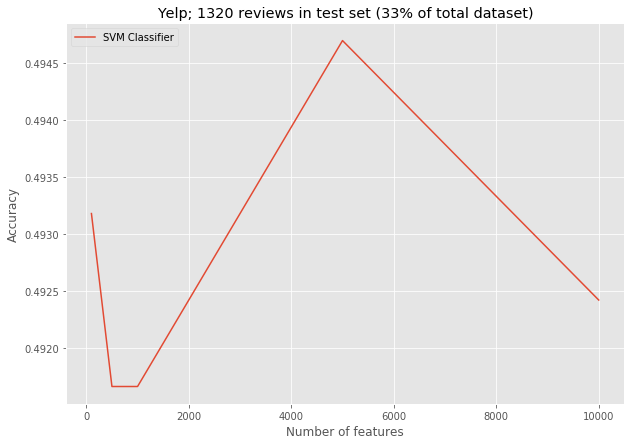

In [371]:
plt.plot(features_number, results["Best score"], label = "SVM Classifier")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Yelp; 1320 reviews in test set (33% of total dataset)")
plt.legend(loc="upper left")
plt.rcParams["figure.figsize"] = (10, 7)

##### Using the raw dataset (unbalanced)

As an experiment, the raw data is fitted into the SVM to compare its performance with the classifiers that learned based on the balanced datasets, the results are logical.
As can be seen, the performance is higher in the unbalanced dataset but not necesarily because the classifier has learned better seeing more reviews, in the unbalanced data set, the number of positive reviews exceed the number of negative by a lot, the classifier has learned how a positive review look like, and it is showing performing better on the test set. Now, ii we feed only negative reviews to this same classifier, probably its performance would not be as good.

##### The number of positive reviews doubles the number of negative ones 

In [373]:
data_raw['Sentiment'].value_counts()

1    44440
0    22258
Name: Sentiment, dtype: int64

In [374]:
scaler = StandardScaler()
pipe = make_pipeline(StandardScaler(), SVC())
param_grid = dict(svc__C = [1e-5, 1e-3, 1, 1e3, 1e5], svc__kernel = ['rbf', 'linear'])
grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [377]:
review_list = data_raw['tokens'].to_numpy()
results2 = {"Number features": [], "Best score": [], "Best Parameters": []}
features_number2 = [100]
y = data_raw['Sentiment'].to_numpy()
for i in features_number2:
    dictio, bow, bow_counted, lenght = restricted_corpus_builder(i, review_list, stop = True)
    X = matrix_builder2(bow, review_list)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
    grid_search.fit(X_train, y_train)
    current_score = grid_search.score(X_test, y_test)
    current_best_est = grid_search.best_estimator_
    results2["Number features"].append(i)
    results2["Best score"].append(current_score)
    results2["Best Parameters"].append(current_best_est)    

#### For the raw dataset, the classifier was only fitter for 100 and 500 dimensions, due to limitations in computational power 

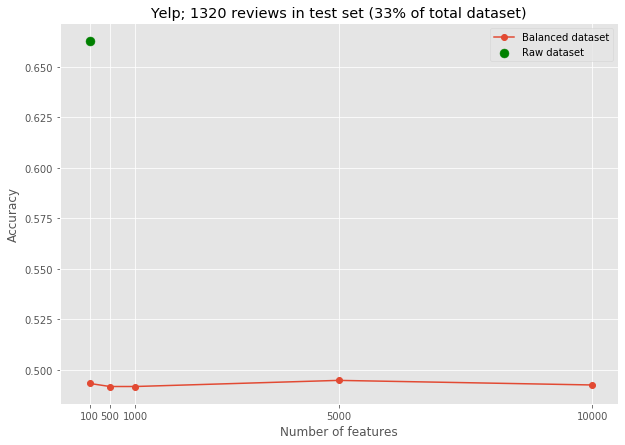

In [417]:
plt.plot(features_number, results["Best score"], label = "Balanced dataset", marker = 'o')
plt.scatter(features_number2[0], results2["Best score"], c = "g", label = "Raw dataset", s = 80)
plt.xticks([100, 500, 1000, 5000, 10000])
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Yelp; 1320 reviews in test set (33% of total dataset)")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"] = (10, 7)

### Now using Naïve Bayes as classifier

In [223]:
from sklearn.naive_bayes import MultinomialNB
pipe2 = make_pipeline(StandardScaler(), MultinomialNB())
param_grid2 = dict(multinomialnb__alpha = [1e-5, 1e-3, 0.1, 0.5, 1])
grid_search2 = GridSearchCV(pipe2, param_grid=param_grid2)
review_list = data2['tokens'].to_numpy()

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('multinomialnb',
                                        MultinomialNB(alpha=1.0,
                                                      class_prior=None,
                                                      fit_prior=True))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'multinomialnb__alpha': [1e-05, 0.001, 0.1, 0.5, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
features_number = [100, 500, 1000, 5000, 10000]
for i in features_number:
    dictio, bow, bow_counted, lenght = restricted_corpus_builder(i, review_list, stop = True)
    X = matrix_builder2(bow, review_list)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
    grid_search2.fit(X_train, y_train)
    current_score = grid_search2.score(X_test, y_test)
    current_best_est = grid_search2.best_estimator_
    results["Number features"].append(i)
    results["Best score"].append(current_score)
    results["Best Parameters"].append(current_best_est)

In [225]:
plt.plot(features_number, results, label = "Naïve Bayes Classifier")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Yelp; 1320 reviews in test set (33% of total dataset)")
plt.legend(loc="upper left")

0.4921212121212121

# Conclusions and further work
<a id='Further'><a/>

#### Conclusions

Being this the first project that I have completed, I feel satisfied with the result, and even more with the things that I have learn. I feel more confident when dealing with concepts of NLP and ML in general: word2vec, embedding, LSTM, regularization, gridsearch, cross validation, etc.

The following are some conclusions from the technical point of view of this project on sentiment analysis:

   - When the features are not high quality -represent fair amount of information on the dimensional space-, it does not matter if more are added, the classifier would still perform poorly. To solve that, one can look for better features and to avoid adding sparse dimensions when possible.
   - One must carefully consider complexity and computational expenditure, is an important topic to take care off, perhaps not very important in this context, when scaling apps, cannot be overlooked

As was stated on the beginning, the objective of this project was to learn about the *classical* algorithms in NLP, (before neural embeddings), that goal was fulfilled, I have had exposure to several applications of computational linguistics and have a ropugh idea to where the field is going Q&A and efficient representations.
Conclusions on *classical NLP* 


  - As can be seen with the process of feature construction, hard coded features were constructed in for this specific problem. That was the way to go for several years, this has several drawbacks, sometimes this features can be transfered to other datasets, (apply the features generated here to a movie review set, for example); but when dealing with other completely different domains, one has to start almost from scratch (pure unigrams/bigrams may be preserved). Neural word representations (Thanks Mikolov?) came to change that by capturing the information of a word using the words that are surrounding that word, **context** met NLP.
  
**On the performance of the classifier**

Comparing these results with the ones obtained by [Pang & Lee (2002)](https://www.aclweb.org/anthology/W02-1011.pdf) in which the used classifications algorithms are the same as in this project, the accuracy is almost the same; which let us daringly conclude that before the introduction of Neural Network representations as input features to an ANN as classification algorithm and of course before the transformers, these accuracy levels were "good".

##### Further work

For further considerations in this line of work is worth considering a couple of avenues. The features constructed are not complex at all, they are simple unigrams with negation tagging, more meaningful features can be constructed with careful thinking depending on the probelm, for this case [Kolchyna et al., (2015)](https://arxiv.org/pdf/1507.00955.pdf) proposed some of the following:
        
        - Word polarity score
        - Emoticons presence
        - Words with negation tagging
        - Parts of speech, specially verbs and adjectives
        - Specific words with a lot of encoded information: happy ,love, excited, great, good

As final comment, and as a personal goal for the auther, stays on the to-do list, the deployment of this trained algorithm in a web app so that the project can be showcased in a better way. It is important also because the goal of data science on a business: generate profits. To do so, the information extractred from the data has to be useful in some way; a web app in this case would be the way to go.